In [1]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType
from datetime import datetime, timedelta
from pydash import py_
from green_city.utils import datetime2index, index2datetime

from green_city.mlflow_config import get_mlflow_config
mlflow.set_tracking_uri(get_mlflow_config()["TRACKING_URI"])
client = MlflowClient()
experiment_id = client.get_experiment_by_name("green_city_experiments").experiment_id

## DB CONNECTION ##
from sqlalchemy import create_engine
from decouple import Config, RepositoryEnv

config = Config(RepositoryEnv("../.db_credentials"))

db_connection_credentials = {
    "database": config('POSTGRES_DB'),
    "user": config('POSTGRES_USER'),
    "password": config('POSTGRES_PASSWORD'),
    "host": config('POSTGRES_HOST'),
    "port": config('POSTGRES_PORT'),
}
DB_STRING = "postgresql://{user}:{password}@{host}:{port}/{database}".format(**db_connection_credentials)
db = create_engine(DB_STRING)

In [2]:
run_ids = [r.run_id for r in client.list_run_infos(experiment_id, run_view_type=ViewType.ACTIVE_ONLY)]

all_runs = {run_id: client.get_run(run_id).to_dictionary() for run_id in run_ids}

In [3]:
runs_dict = {}

for id, details in all_runs.items():
    start_time = py_.get(details, "info.start_time")
    end_time = py_.get(details, "info.end_time")
    delta = round(end_time/1000 - start_time/1000, 2)
    runs_dict[id] = {
        "time_s": delta,
        **py_.get(details, "data.metrics"),
        **py_.get(details, "data.params")
    }

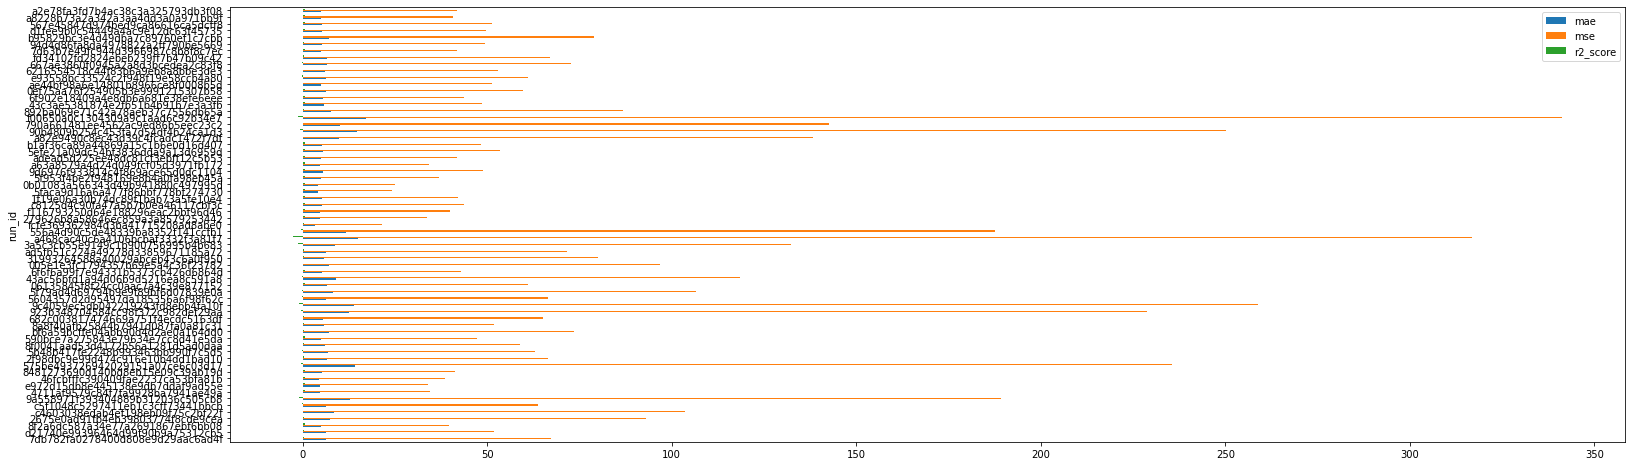

In [7]:
df = pd.DataFrame.from_dict(runs_dict, orient='index')
df = (df
.assign(index = df['index'].fillna(0))
.astype({"datetime": "datetime64[ns]", "index": "int", "train_steps": "float"})
)

df.index = df.index.rename("run_id")

plt.rcParams['figure.figsize'] = [25, 8]
df[df.feature=="net_load_kWh"].loc[:, ["mae", "mse", "r2_score"]].plot.barh()
#df[df.feature=="net_load_kWh"].loc[:, ["time_s"]].plot.barh()
df.to_csv("../data/results/evaluation_matrix.csv")

<Figure size 864x288 with 0 Axes>

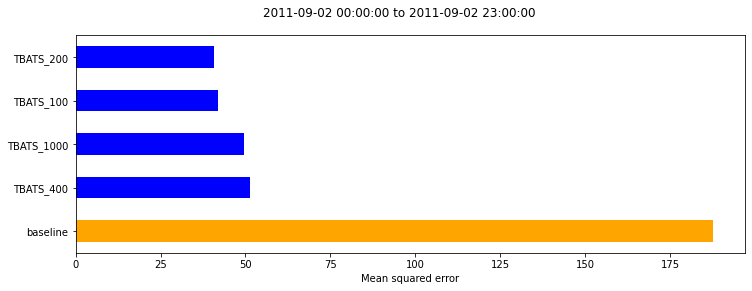

<Figure size 864x288 with 0 Axes>

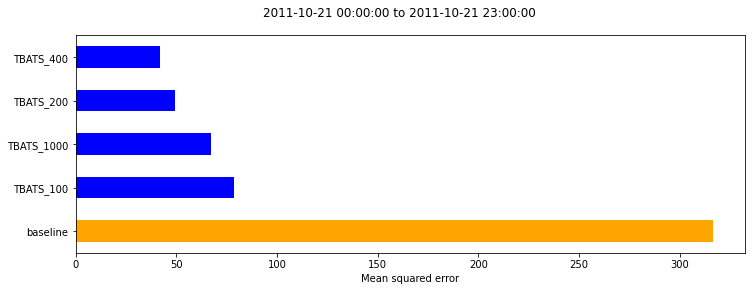

<Figure size 864x288 with 0 Axes>

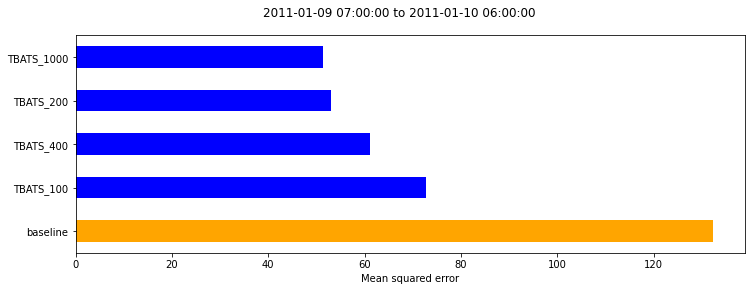

<Figure size 864x288 with 0 Axes>

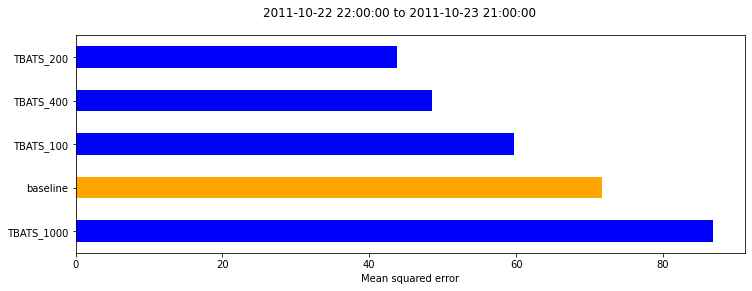

<Figure size 864x288 with 0 Axes>

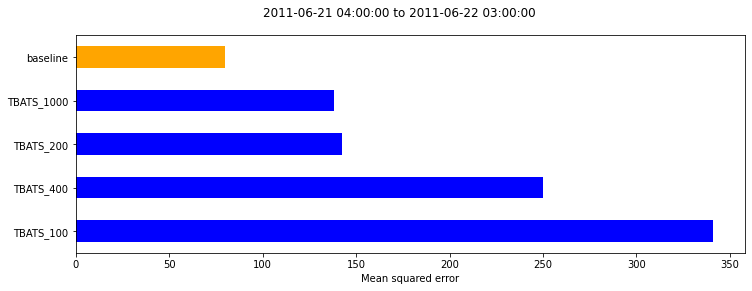

<Figure size 864x288 with 0 Axes>

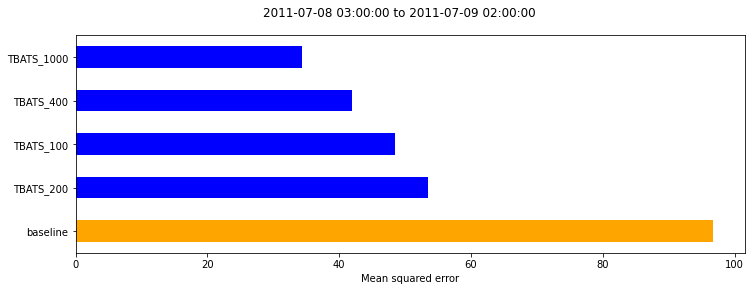

<Figure size 864x288 with 0 Axes>

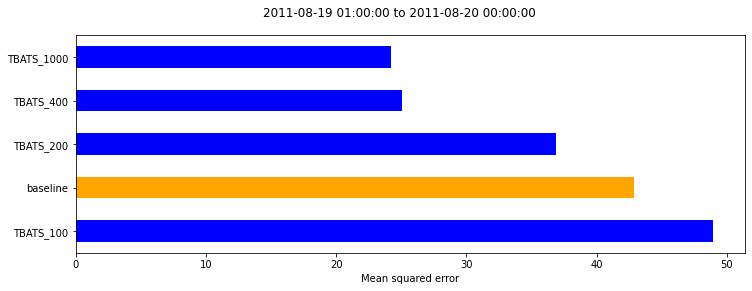

<Figure size 864x288 with 0 Axes>

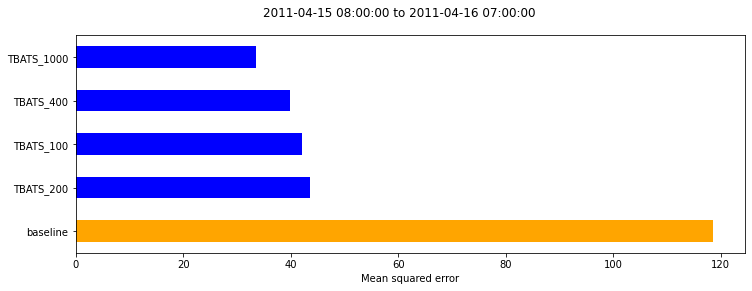

In [8]:
plt.rcParams['figure.figsize'] = [12, 4]

def steps2str(v):
    if np.isnan(v):
        return ""
    return f"_{str(int(v))}"
    
model2color = {
    "baseline": "orange",
    "TBATS": "blue",
}

indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
for index in indices:
    fig = plt.figure()
    plot_df = (df[df["index"] == index]
                .sort_values("mse", ascending=False)
                .assign(col = lambda x:x["model"].map(lambda x: model2color.get(x, "black")))
                #.assign(label = lambda x: f"{x['model']}{steps2str(x['train_steps'])}")
    )
    plot_df['submodel'] = plot_df['train_steps'].map(steps2str)
    plot_df['label'] = [''.join(i) for i in zip(plot_df['model'], plot_df['submodel'])]
    plot_df.plot.barh(x="label", y="mse", color=plot_df["col"], legend=None)
    plt.xlabel("Mean squared error")
    plt.ylabel(None)
    plt.suptitle(f"{str(index2datetime(index+1))} to {str(index2datetime(index+24))}")

In [9]:
# Load the actual dataset
def get_df(building_nr, feature):
    df = (
    pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv")
        .astype({'datetime': 'datetime64'})
        [[feature, "datetime"]]
        .rename(columns={feature: "actual"})
    )
    df.index.name = "id"
    return df

actual_df = get_df(5, "net_load_kWh")

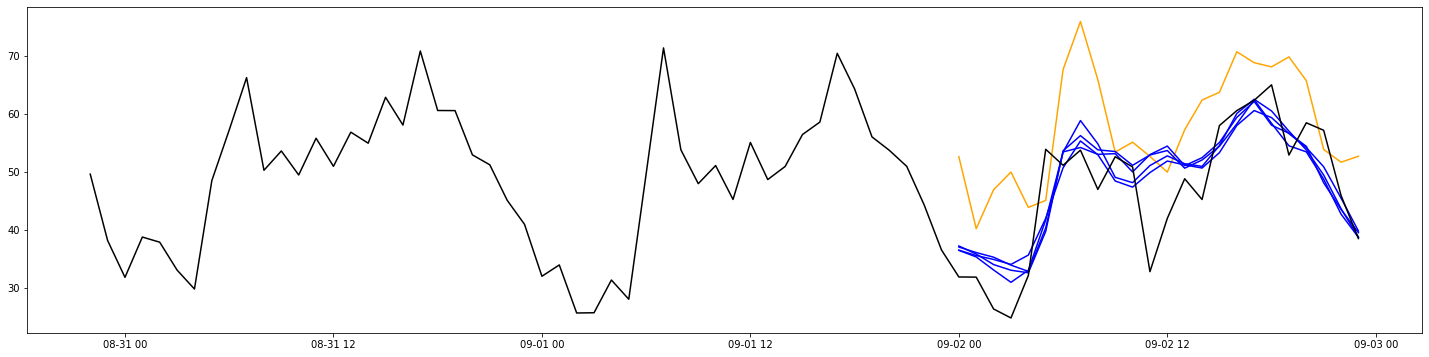

In [10]:
plt.rcParams['figure.figsize'] = [25, 6]

index_to_plot = indices[0]
plot_df = df[df["index"] == index_to_plot]
plot_df

y_true = actual_df.loc[index_to_plot+1-50:index_to_plot+24].set_index("datetime")

for run_id, run_data in plot_df.iterrows():
    query_string = f"SELECT * FROM forecast WHERE run_id='{run_id}'" # LIMIT 10"
    run_predictions = pd.read_sql(query_string, db).drop(columns="run_id")
    run_predictions["datetime"] = run_predictions["id"].map(index2datetime)#y_true.index
    color = model2color[run_data.model]
    plt.plot(run_predictions.drop(columns=["id"]).set_index("datetime"), color=color)
plt.plot(y_true, color="black");

In [ ]:
query_string = "SELECT * FROM forecast" # LIMIT 10"
run_predictions = pd.read_sql(query_string, db)

In [ ]:
len(run_predictions)

In [ ]:
indices = [32135, 33311, 26478, 33357, 30387, 30794, 31800, 28783]
times = [(index2datetime(i), i+1, i+24) for i in indices]
display(times)

# upload building data from csv to database

In [ ]:
if False:
    building_nr = 5
    df = pd.read_csv(f"../data/preprocessed/Building_{building_nr}.csv").astype({'datetime': 'datetime64'})
    df.index.name = "id"
    
    df.to_sql("building5", con=db)